# Numpy构建两层神经网络分类器

In [94]:
%matplotlib inline
import numpy
import os
import gzip
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt

## 训练

激活函数

In [63]:
#定义sigmoid、relu、softmax
def sigmoid(input):
    return 1/(1+np.exp(-input))

def sigmoid_gradient(input):
    return sigmoid(input) * (1-sigmoid(input))

def relu(input):
    return np.maximum(0, input)

def relu_gradient(input):
    return input > 0

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))


神经网络模型

In [64]:
class NeuralNetwork:
    
    def __init__(self, sizes):
        '''
        初始化神经网络
        '''
        self.sizes = sizes
        self.num_layers = len(sizes)
        # 初始化权重，输入层没有权重和偏置
        self.weights = [np.array([0])] + [np.random.randn(y, x)/np.sqrt(x) for y, x in zip(sizes[1:], sizes[:-1])]
        self.biases = [np.array([0])] + [np.random.randn(x, 1) for x in sizes[1:]]
        # 存储线性变换的结果
        self.linear_transforms = [np.zeros(bias.shape) for bias in self.biases]
        # 存储非线性变换的结果
        self.activations = [np.zeros(bias.shape) for bias in self.biases]
    
    def forward(self, input):
        '''
        前向传播
        '''
        self.activations[0] = input
        for i in range(1, self.num_layers):
            # 线性变换
            self.linear_transforms[i] = self.weights[i].dot(self.activations[i-1]) + self.biases[i]
            # 非线性变换
            # 在最后一层使用softmax激活函数
            if i == self.num_layers-1:
                self.activations[i] = softmax(self.linear_transforms[i])
            else:
                self.activations[i] = relu(self.linear_transforms[i])
        return self.activations[-1]
    
    def backward(self, loss_gradient):
        '''
        反向传播   
        `loss_gradient`为损失函数的求导结果
        '''
        nabla_b = [np.zeros(bias.shape) for bias in self.biases]
        nabla_w = [np.zeros(weight.shape) for weight in self.weights]

        nabla_b[-1] = loss_gradient
        nabla_w[-1] = loss_gradient.dot(self.activations[-2].transpose())

        for layer in range(self.num_layers-2, 0, -1):
            loss_gradient = np.multiply(
                self.weights[layer+1].transpose().dot(loss_gradient),
                relu_gradient(self.linear_transforms[layer])
            )
            nabla_b[layer] = loss_gradient
            nabla_w[layer] = loss_gradient.dot(self.activations[layer-1].transpose())
        
        return nabla_b, nabla_w
    
    def save(self, filename):
        np.savez_compressed(
            file=os.path.join(os.curdir, 'models', filename),
            weights=self.weights,
            biases=self.biases,
            linear_transforms=self.linear_transforms,
            activations=self.activations
        )
    
    def load(self, filename):
        npz_members = np.load(os.path.join(os.curdir, 'models', filename), allow_pickle=True)

        self.weights = list(npz_members['weights'])
        self.biases = list(npz_members['biases'])

        self.sizes = [b.shape[0] for b in self.biases]
        self.num_layers = len(self.sizes)

        self.linear_transforms = list(npz_members['linear_transforms'])
        self.activations = list(npz_members['activations'])

SGD优化器

In [65]:
class SGD:

    def __init__(self, model, learning_rate, weight_decay, batch_size):
        self.model = model
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size

        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def zero_grad(self):
        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def update(self, delta_nabla_b, delta_nabla_w):
        self.nabla_b = [nb + dnb for nb, dnb in zip(self.nabla_b, delta_nabla_b)]
        self.nabla_w = [nw + dnw for nw, dnw in zip(self.nabla_w, delta_nabla_w)]

    def step(self):
        # 参数更新
        # 使用batch gradient descent，因此学习率要除以batch_size
        self.model.weights = [(1 - self.lr * self.weight_decay) * w - (self.lr / self.batch_size) * dw for w, dw in zip(self.model.weights, self.nabla_w)]
        self.model.biases = [(1 - self.lr * self.weight_decay) * b - (self.lr / self.batch_size) * db for b, db in zip(self.model.biases, self.nabla_b)]


训练

In [66]:
def test(model, test_data):
    res = []
    for input, label in test_data:
        output = model.forward(input)
        res.append(np.argmax(output) == np.argmax(label))
    accuracy = sum(res) / 100.0
    print(f"****Test accuracy {accuracy} %.")

In [67]:
def fit(model, optimizer, training_data, validation_data, epochs):
    best_accuracy = 0
    train_losses = []
    validate_losses = []
    accuracies = []
    for epoch in range(epochs):
        # validate
        validate_loss = 0
        res = []
        for input, label in validation_data:
            output = model.forward(input)
            validate_loss += np.where(label==1, -np.log(output), 0).sum()
            res.append(np.argmax(output) == np.argmax(label))
        validate_loss /= len(validation_data)
        validate_losses.append(validate_loss)
        accuracy = sum(res) / 100.0
        accuracies.append(accuracy)
        # train
        random.shuffle(training_data)
        batches = [training_data[k:k+optimizer.batch_size] for k in range(0, len(training_data), optimizer.batch_size)]
        train_loss = 0
        for batch in batches:
            optimizer.zero_grad()
            for input, label in batch:
                output = model.forward(input)
                # loss为交叉熵损失函数
                train_loss  += np.where(label==1, -np.log(output), 0).sum()
                # cross entropy loss + softmax 的导数
                loss_gradient = output - label
                delta_nabla_b, delta_nabla_w = model.backward(loss_gradient)
                optimizer.update(delta_nabla_b, delta_nabla_w)
            optimizer.step()
        train_loss /= len(training_data)
        train_losses.append(train_loss)
        # save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save(f"model_{model.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.npz")
        print(f"****Epoch {epoch+1}, accuracy {accuracy} %.")
    # save log
    data = {
        "train_loss": train_losses,
        "validate_loss": validate_losses,
        "validate_accuracy": accuracies
    }
    pd.DataFrame(data).to_csv(f'logs/log_{model.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.csv',)
    return best_accuracy

In [68]:
def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

In [69]:
def load_mnist():
    data_file = gzip.open(os.path.join(os.curdir, "datasets", "mnist.pkl.gz"), "rb")
    train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
    data_file.close()

    train_inputs = [np.reshape(x, (784, 1)) for x in train_data[0]]
    train_results = [vectorized_result(y) for y in train_data[1]]
    train_data = list(zip(train_inputs, train_results))

    val_inputs = [np.reshape(x, (784, 1)) for x in val_data[0]]
    val_results = [vectorized_result(y) for y in val_data[1]]
    val_data = list(zip(val_inputs, val_results))

    test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
    test_results = [vectorized_result(y) for y in test_data[1]]
    test_data = list(zip(test_inputs, test_results))
    
    return train_data, val_data, test_data

## 参数查找

设置随机种子

In [71]:
np.random.seed(42)

超参数

In [81]:
batch_size = 16
epochs= 80
layers = [[784, 20, 10], [784, 30, 10], [784, 40, 10]]
learning_rates = [5e-3, 1e-2, 2e-2]
weight_decaies = [1e-2, 2e-2] # L2 正则化

载入数据

In [82]:
train_data, val_data, test_data = load_mnist()

Training--参数查找

In [83]:
best_config = {'accuracy': 0}
for layer in layers:
    for learning_rate in learning_rates:
        for weight_decay in weight_decaies:
            print(f"**Current layer: {layer}, Current learning rate: {learning_rate}, Current weight decay: {weight_decay}")
            model = NeuralNetwork(layer)
            optimizer = SGD(model, learning_rate, weight_decay, batch_size)
            accuracy = fit(model, optimizer, train_data, val_data, epochs)
            if accuracy > best_config['accuracy']:
                best_config['accuracy'] = accuracy
                best_config['layer'] = layer
                best_config['learning_rate'] = learning_rate
                best_config['weight_decay'] = weight_decay

**Current layer: [784, 20, 10], Current learning rate: 0.005, Current weight decay: 0.01


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


****Epoch 1, accuracy 9.9 %.
****Epoch 2, accuracy 87.89 %.
****Epoch 3, accuracy 89.84 %.
****Epoch 4, accuracy 90.7 %.
****Epoch 5, accuracy 91.35 %.
****Epoch 6, accuracy 91.61 %.
****Epoch 7, accuracy 91.97 %.
****Epoch 8, accuracy 92.13 %.
****Epoch 9, accuracy 92.25 %.
****Epoch 10, accuracy 92.42 %.
****Epoch 11, accuracy 92.49 %.
****Epoch 12, accuracy 92.68 %.
****Epoch 13, accuracy 92.77 %.
****Epoch 14, accuracy 92.75 %.
****Epoch 15, accuracy 92.67 %.
****Epoch 16, accuracy 92.94 %.
****Epoch 17, accuracy 92.72 %.
****Epoch 18, accuracy 92.78 %.
****Epoch 19, accuracy 92.96 %.
****Epoch 20, accuracy 92.87 %.
****Epoch 21, accuracy 92.93 %.
****Epoch 22, accuracy 93.02 %.
****Epoch 23, accuracy 93.0 %.
****Epoch 24, accuracy 92.99 %.
****Epoch 25, accuracy 93.19 %.
****Epoch 26, accuracy 93.09 %.
****Epoch 27, accuracy 93.24 %.
****Epoch 28, accuracy 93.19 %.
****Epoch 29, accuracy 93.25 %.
****Epoch 30, accuracy 93.09 %.
****Epoch 31, accuracy 93.22 %.
****Epoch 32, accurac

****Epoch 11, accuracy 91.24 %.
****Epoch 12, accuracy 91.44 %.
****Epoch 13, accuracy 91.51 %.
****Epoch 14, accuracy 91.53 %.
****Epoch 15, accuracy 91.6 %.
****Epoch 16, accuracy 91.53 %.
****Epoch 17, accuracy 91.57 %.
****Epoch 18, accuracy 91.48 %.
****Epoch 19, accuracy 91.62 %.
****Epoch 20, accuracy 91.59 %.
****Epoch 21, accuracy 91.63 %.
****Epoch 22, accuracy 91.66 %.
****Epoch 23, accuracy 91.67 %.
****Epoch 24, accuracy 91.53 %.
****Epoch 25, accuracy 91.71 %.
****Epoch 26, accuracy 91.75 %.
****Epoch 27, accuracy 91.5 %.
****Epoch 28, accuracy 91.61 %.
****Epoch 29, accuracy 91.85 %.
****Epoch 30, accuracy 91.49 %.
****Epoch 31, accuracy 91.79 %.
****Epoch 32, accuracy 91.7 %.
****Epoch 33, accuracy 91.65 %.
****Epoch 34, accuracy 91.59 %.
****Epoch 35, accuracy 91.58 %.
****Epoch 36, accuracy 91.42 %.
****Epoch 37, accuracy 91.6 %.
****Epoch 38, accuracy 91.61 %.
****Epoch 39, accuracy 91.66 %.
****Epoch 40, accuracy 91.49 %.
****Epoch 41, accuracy 91.72 %.
****Epoch 42

****Epoch 21, accuracy 92.79 %.
****Epoch 22, accuracy 92.95 %.
****Epoch 23, accuracy 92.88 %.
****Epoch 24, accuracy 92.92 %.
****Epoch 25, accuracy 92.97 %.
****Epoch 26, accuracy 92.94 %.
****Epoch 27, accuracy 92.95 %.
****Epoch 28, accuracy 92.98 %.
****Epoch 29, accuracy 92.97 %.
****Epoch 30, accuracy 93.09 %.
****Epoch 31, accuracy 93.14 %.
****Epoch 32, accuracy 93.01 %.
****Epoch 33, accuracy 93.1 %.
****Epoch 34, accuracy 93.05 %.
****Epoch 35, accuracy 93.22 %.
****Epoch 36, accuracy 93.22 %.
****Epoch 37, accuracy 93.14 %.
****Epoch 38, accuracy 93.07 %.
****Epoch 39, accuracy 93.23 %.
****Epoch 40, accuracy 93.15 %.
****Epoch 41, accuracy 93.34 %.
****Epoch 42, accuracy 93.33 %.
****Epoch 43, accuracy 93.37 %.
****Epoch 44, accuracy 93.27 %.
****Epoch 45, accuracy 93.15 %.
****Epoch 46, accuracy 93.08 %.
****Epoch 47, accuracy 93.31 %.
****Epoch 48, accuracy 93.27 %.
****Epoch 49, accuracy 93.27 %.
****Epoch 50, accuracy 93.2 %.
****Epoch 51, accuracy 93.29 %.
****Epoch 

****Epoch 31, accuracy 91.95 %.
****Epoch 32, accuracy 92.03 %.
****Epoch 33, accuracy 92.03 %.
****Epoch 34, accuracy 92.06 %.
****Epoch 35, accuracy 92.1 %.
****Epoch 36, accuracy 92.22 %.
****Epoch 37, accuracy 92.15 %.
****Epoch 38, accuracy 92.11 %.
****Epoch 39, accuracy 92.16 %.
****Epoch 40, accuracy 91.95 %.
****Epoch 41, accuracy 92.26 %.
****Epoch 42, accuracy 92.14 %.
****Epoch 43, accuracy 92.24 %.
****Epoch 44, accuracy 92.21 %.
****Epoch 45, accuracy 92.23 %.
****Epoch 46, accuracy 92.12 %.
****Epoch 47, accuracy 92.07 %.
****Epoch 48, accuracy 92.07 %.
****Epoch 49, accuracy 92.21 %.
****Epoch 50, accuracy 92.18 %.
****Epoch 51, accuracy 92.16 %.
****Epoch 52, accuracy 92.05 %.
****Epoch 53, accuracy 92.29 %.
****Epoch 54, accuracy 92.18 %.
****Epoch 55, accuracy 92.07 %.
****Epoch 56, accuracy 91.96 %.
****Epoch 57, accuracy 91.95 %.
****Epoch 58, accuracy 92.15 %.
****Epoch 59, accuracy 92.1 %.
****Epoch 60, accuracy 92.09 %.
****Epoch 61, accuracy 92.16 %.
****Epoch 

****Epoch 41, accuracy 93.42 %.
****Epoch 42, accuracy 93.5 %.
****Epoch 43, accuracy 93.51 %.
****Epoch 44, accuracy 93.62 %.
****Epoch 45, accuracy 93.7 %.
****Epoch 46, accuracy 93.64 %.
****Epoch 47, accuracy 93.76 %.
****Epoch 48, accuracy 93.78 %.
****Epoch 49, accuracy 93.78 %.
****Epoch 50, accuracy 93.87 %.
****Epoch 51, accuracy 93.65 %.
****Epoch 52, accuracy 93.81 %.
****Epoch 53, accuracy 93.93 %.
****Epoch 54, accuracy 93.86 %.
****Epoch 55, accuracy 93.89 %.
****Epoch 56, accuracy 93.96 %.
****Epoch 57, accuracy 93.89 %.
****Epoch 58, accuracy 93.85 %.
****Epoch 59, accuracy 94.04 %.
****Epoch 60, accuracy 93.84 %.
****Epoch 61, accuracy 94.02 %.
****Epoch 62, accuracy 94.07 %.
****Epoch 63, accuracy 94.06 %.
****Epoch 64, accuracy 93.93 %.
****Epoch 65, accuracy 93.96 %.
****Epoch 66, accuracy 93.96 %.
****Epoch 67, accuracy 93.99 %.
****Epoch 68, accuracy 94.0 %.
****Epoch 69, accuracy 93.9 %.
****Epoch 70, accuracy 94.07 %.
****Epoch 71, accuracy 93.98 %.
****Epoch 72

****Epoch 51, accuracy 92.4 %.
****Epoch 52, accuracy 92.34 %.
****Epoch 53, accuracy 92.26 %.
****Epoch 54, accuracy 92.29 %.
****Epoch 55, accuracy 92.31 %.
****Epoch 56, accuracy 92.01 %.
****Epoch 57, accuracy 92.19 %.
****Epoch 58, accuracy 92.3 %.
****Epoch 59, accuracy 92.36 %.
****Epoch 60, accuracy 92.34 %.
****Epoch 61, accuracy 92.31 %.
****Epoch 62, accuracy 92.17 %.
****Epoch 63, accuracy 92.14 %.
****Epoch 64, accuracy 92.08 %.
****Epoch 65, accuracy 92.37 %.
****Epoch 66, accuracy 92.21 %.
****Epoch 67, accuracy 92.18 %.
****Epoch 68, accuracy 92.38 %.
****Epoch 69, accuracy 92.29 %.
****Epoch 70, accuracy 92.2 %.
****Epoch 71, accuracy 92.23 %.
****Epoch 72, accuracy 92.28 %.
****Epoch 73, accuracy 92.39 %.
****Epoch 74, accuracy 92.29 %.
****Epoch 75, accuracy 92.24 %.
****Epoch 76, accuracy 92.36 %.
****Epoch 77, accuracy 92.24 %.
****Epoch 78, accuracy 92.35 %.
****Epoch 79, accuracy 92.24 %.
****Epoch 80, accuracy 92.05 %.
**Current layer: [784, 40, 10], Current lea

In [88]:
best_config

{'accuracy': 94.44,
 'layer': [784, 40, 10],
 'learning_rate': 0.02,
 'weight_decay': 0.01}

训练结果显示，当参数为：layer:[784,40,10],learning rate0.02，weight decay0.01，在训练集上的accuracy达到94.22%，为最优。

Testing

In [89]:
model = NeuralNetwork(best_config['layer'])
model.load(f"model_{best_config['layer'][1]}_{best_config['learning_rate']}_{best_config['weight_decay']}.npz")
test(model, test_data)

****Test accuracy 93.6 %.


结果可视化

In [98]:
log = pd.read_csv(f"logs/log_{best_config['layer'][1]}_{best_config['learning_rate']}_{best_config['weight_decay']}.csv")

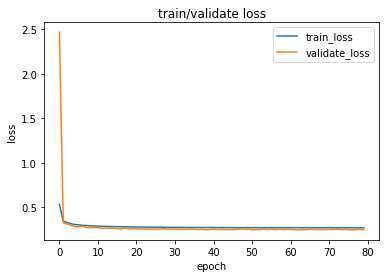

In [99]:
# 可视化训练和测试的loss曲线
log[['train_loss','validate_loss']].plot(title='train/validate loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("figs/loss.png")
plt.show()
plt.close()

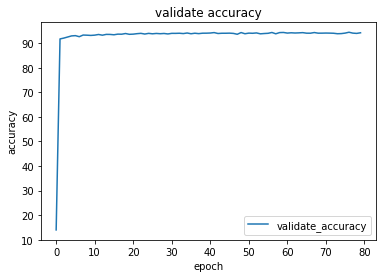

In [100]:
# 可视化测试的accuracy曲线
log[['validate_accuracy']].plot(title='validate accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("figs/accuracy.png")
plt.show()
plt.close()

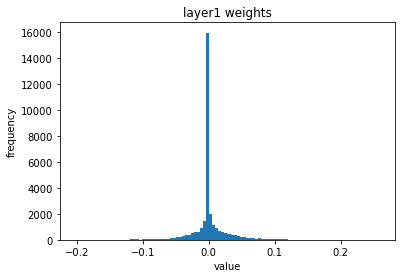

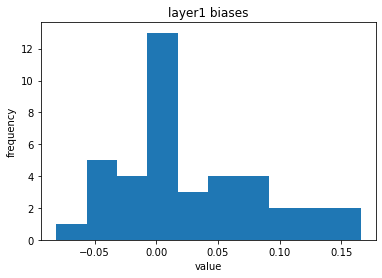

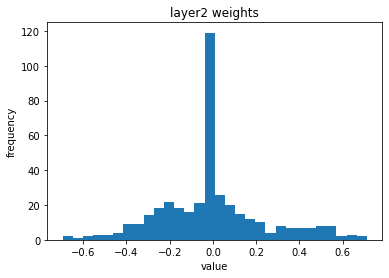

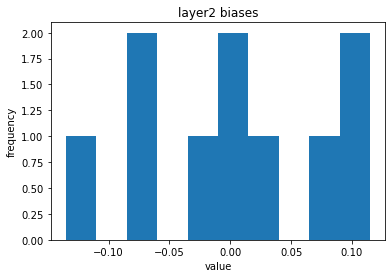

In [102]:
#可视化每层的网络参数
#第一层的weights
layer1_weights = model.weights[1].flatten().tolist()
plt.hist(layer1_weights, bins=100)
plt.title("layer1 weights")
plt.xlabel("value")
plt.ylabel("frequency")
plt.savefig("figs/layer1_weights.png")
plt.show()
plt.close()

#第一层的biases
layer1_biases = model.biases[1].flatten().tolist()
plt.hist(layer1_biases, bins=10)
plt.title("layer1 biases")
plt.xlabel("value")
plt.ylabel("frequency")
plt.savefig("figs/layer1_biases.png")
plt.show()
plt.close()

#第二层的weights
layer2_weights = model.weights[2].flatten().tolist()
plt.hist(layer2_weights, bins=30)
plt.title("layer2 weights")
plt.xlabel("value")
plt.ylabel("frequency")
plt.savefig("figs/layer2_weights.png")
plt.show()
plt.close()

#第二层的biases
layer2_biases = model.biases[2].flatten().tolist()
plt.hist(layer2_biases, bins=10)
plt.title("layer2 biases")
plt.xlabel("value")
plt.ylabel("frequency")
plt.savefig("figs/layer2_biases.png")
plt.show()
plt.close()

# github链接

https://github.com/weicanliu99/HW1

# 模型存放在百度网盘中

链接: https://pan.baidu.com/s/1aD6tNdewhPDruZJLjJuaPA?pwd=4yq2 提取码: 4yq2 复制这段内容后打开百度网盘手机App，操作更方便哦